In [1]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math


/home/nutapolt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

In [4]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = ''
        self.path = path
        print(path)
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    
        
        print("Done.")
        return self.raw
    def filter(self, freq):
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    def raw_ica(self):
        raw = self.raw
        ica = mne.preprocessing.ICA(n_components=1, max_iter=100)
        ica.fit(raw)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw, picks=ica.exclude)
        ica.apply(raw)
        print('ICA DONE ????')
        return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    
        
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        #print(f">>> Extract all subjects from: {fullpath}.")
        extension = "fif"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                #print(path_file)
                #print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        print("Done.")
        return events , event_id
# getepoch(raw,4, 10,reject_bad=False,on_missing='warn')    
    def get_X_y(self):
        events = mne.find_events(raw)
        
        epochs = mne.Epochs(
        raw,
        events,
        event_id=[1,2,3],
        tmin=-2,
        tmax=2,
        picks="data",
        on_missing='warn',
        baseline=None
    )
            
            #events , event_id=self.create_epochs()
        self.X = epochs.get_data()
        self.y = epochs.events[:, -1]
        return self.X, self.y 

        
def getepoch(raws,trial_duration, calibration_duration,reject_bad=False,on_missing='warn'):
    #reject_criteria = dict(eeg=100e-6)  # 100 µV
    #flat_criteria = dict(eeg=1e-6)  # 1 µV
    epochs_list = []
    raws = [raws]
    print(len(raws))
    for raw in raws:
        print(raw)
        events = mne.find_events(raw)
        epochs = mne.Epochs(
            raw,
            events,
            event_id=[1,2,3],
            tmin=-calibration_duration,
            tmax=trial_duration,
            picks="data",
            on_missing=on_missing,
            baseline=None
        )
        
        epochs_list.append(epochs)
    epochs = mne.concatenate_epochs(epochs_list)
    labels = epochs.events[:,-1]
    
    print(f'Found {len(labels)} epochs')
    print(epochs)
    print(labels)

    return epochs.get_data(),epochs,labels

        
        
def do_plot(train_loss, valid_loss,ty):
    if ty == "loss":
        plt.figure(figsize=(10,10))
        
        plt.plot(train_loss, label='train_loss')
        plt.plot(valid_loss, label='valid_loss')
        plt.title('loss {}'.format(iter))
        plt.legend()
        plt.show()
    if ty == "acc":
        plt.figure(figsize=(10,10))
        
        plot_ty=torch.tensor(train_loss, device = 'cpu')
        plat_va=torch.tensor(valid_loss, device = 'cpu')
        plt.plot(plot_ty, label='train_acc')
        plt.plot(plat_va, label='valid_acc')
        plt.title('acc {}'.format(iter))
        plt.legend()
        plt.show()

In [5]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [3, 5, 7]
subjects = [i for i in range(2,3)]
#subjects = [1]
# runs = [6,10,14]
print(path)
eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
freq = (1., 45.)
raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()
#eeg.create_epochs()

/tmp/ipykernel_13810/2543180692.py:71: RuntimeWarning: This filename (S002/S002R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/tmp/ipykernel_13810/2543180692.py:71: RuntimeWarning: This filename (S002/S002R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/tmp/ipykernel_13810/2543180692.py:71: RuntimeWarning: This filename (S002/S002R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _i

Raw done
>>> Apply filter.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_13810/2543180692.py:71: RuntimeWarning: This filename (S002/S002R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/tmp/ipykernel_13810/2543180692.py:71: RuntimeWarning: This filename (S002/S002R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )


Filter done


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


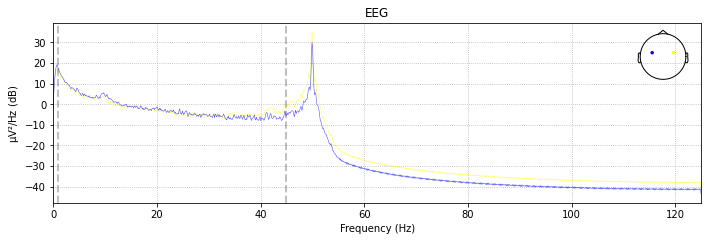

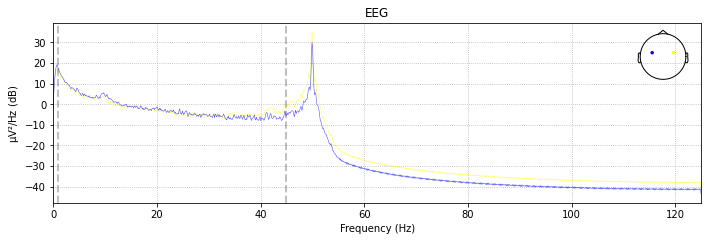

In [6]:
eeg.raw.plot_psd()

In [7]:
X, y = eeg.get_X_y()

144 events found
Event IDs: [1 2 4]
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 1001 original time points ...
3 bad epochs dropped


/tmp/ipykernel_13810/2543180692.py:92: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [7]:
#X = X[:, :,np.newaxis,:]
print(X.shape)
y=y-1
y

(69, 2, 1001)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train size (55, 2, 1001) (55,)
Test size (14, 2, 1001) (14,)


In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

num_step =math.ceil(len(train_loader.dataset) / batch_size)

In [10]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv1d(2, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(128128, 2)
        self.drop_out = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [11]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nutapol-1997. Use `wandb login --relogin` to force relogin


True

In [16]:

wand = wandb.init(
        
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"OurData_CNN_2ch_2class", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.00001,
      "architecture": "CNN",
      "dataset": "Nutapol T.",
      "epochs": 10000,
      "weightname":"OurData_CNN_2ch_2class",
      "num_step_per_epoch" : num_step, 
        
      }
    )



train/train_accuracy,▆▄▃▁▄▃▅▆█▅▁▅▃▄▄▄▇▄▆▆▆▆▄▅▄▄▁▅▄▅▄▅▇▆▆▆▄▄▄▅
train/train_loss,▄▇▇▇▅▇▆▂▃▄▃▃▄▄▆▃▅▂▃▅▁▂▄▃▂▄▅▁▄▅▅▂▂▇▆▂█▄▂▂
val/val_accuracy,██████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_loss,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
train/train_accuracy,54.54545
train/train_loss,0.69938
val/val_accuracy,42.85714
val/val_loss,0.70341


In [17]:
config = wand.config
print(config.num_step_per_epoch)

2


In [18]:
from common import train

In [19]:
net = ConvNet().cuda(0)
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()


train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    gpu_num = 0,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    wand = wand
         )


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

Epoch 1/10000, Tr Loss: 0.7415, Tr Acc: 40.0000, Val Loss: 0.6920, Val Acc: 57.1429
Epoch 51/10000, Tr Loss: 0.4766, Tr Acc: 87.2727, Val Loss: 0.6887, Val Acc: 42.8571
Epoch 101/10000, Tr Loss: 0.3382, Tr Acc: 94.5454, Val Loss: 0.6438, Val Acc: 57.1429
Epoch 151/10000, Tr Loss: 0.2388, Tr Acc: 98.1818, Val Loss: 0.7164, Val Acc: 57.1429
Epoch 201/10000, Tr Loss: 0.1787, Tr Acc: 98.1818, Val Loss: 0.6411, Val Acc: 64.2857
Epoch 251/10000, Tr Loss: 0.1199, Tr Acc: 100.0000, Val Loss: 0.6708, Val Acc: 71.4286
Epoch 301/10000, Tr Loss: 0.1027, Tr Acc: 100.0000, Val Loss: 0.6217, Val Acc: 71.4286
Epoch 351/10000, Tr Loss: 0.0593, Tr Acc: 100.0000, Val Loss: 0.6101, Val Acc: 78.5714
Epoch 401/10000, Tr Loss: 0.0548, Tr Acc: 100.0000, Val Loss: 0.6375, Val Acc: 78.5714
Epoch 451/10000, Tr Loss: 0.0419, Tr Acc: 100.0000, Val Loss: 0.6301, Val Acc: 57.1429
Epoch 501/10000, Tr Loss: 0.0348, Tr Acc: 100.0000, Val Loss: 0.6410, Val Acc: 78.5714
Epoch 551/10000, Tr Loss: 0.0300, Tr Acc: 100.0000,

### GAMENET

In [64]:
class gamenet(nn.Module):
    def __init__(self):
        
        super(gamenet,self).__init__()
        
        self.l1 = nn.Sequential(
            #in_channel = 16
            #out_channel or Filter size = 100
            #kernel size = (1,25)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(2,100,kernel_size=(1,2),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l2 = nn.Sequential(
            #in_channel = 100
            #out_channel or Filter size = 100
            #kernel size = (16,1)
            #stride = 1
            #padding = Valid
            #Relu
            nn.Conv2d(100,100,kernel_size=(1,2),stride=1,padding='valid'),
            #nn.Conv2d(100,100,kernel_size=(64,1),stride=1,padding='valid'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l3 = nn.Sequential(
            #in_channel = 100
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(100,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling1 = nn.MaxPool2d(kernel_size=(1,7),stride=5)
        self.l4 = nn.Sequential(
            #in_channel = 50
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(50,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling2 = nn.MaxPool2d(kernel_size=(1,3),stride=2)
        

        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(4950),
            nn.Dropout(0.15)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(4950 ,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.15)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.15)
        )
        self.fc5 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15)
        )
        self.fc6 = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.15)
        )
        self.softmax = nn.Sequential(
            nn.Linear(32,2),
            nn.Softmax()
        )
    def forward(self,x):
        
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.maxpooling1(out)
        out = self.l4(out)
        out = self.maxpooling2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        out = self.softmax(out)
        return out

In [65]:
X, y = eeg.get_X_y()
X = X[:, :,np.newaxis,:]
print(X.shape)
y=y-1
y

144 events found
Event IDs: [1 2 4]
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 1001 original time points ...
3 bad epochs dropped
(69, 2, 1, 1001)


/tmp/ipykernel_3622/2543180692.py:92: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

num_step =math.ceil(len(train_loader.dataset) / batch_size)

train size (48, 2, 1, 1001) (48,)
Test size (21, 2, 1, 1001) (21,)


In [67]:

wand = wandb.init(
        
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"OurData_gamenet_2ch_2class", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.00001,
      "architecture": "gamenet",
      "dataset": "Nutapol T.",
      "epochs": 20000,
      "weightname":"OurData_gamenet_2ch_2class",
      "num_step_per_epoch" : num_step, 
        
      }
    )
config = wand.config
print(config.num_step_per_epoch)


2


In [68]:
from common import train

In [70]:
net = gamenet().cuda(0)
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()


train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    gpu_num = 0,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    wand = wand
         )


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

/home/nutapolt/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/20000, Tr Loss: 0.6743, Tr Acc: 60.4167, Val Loss: 0.6894, Val Acc: 61.9048
Epoch 51/20000, Tr Loss: 0.5404, Tr Acc: 85.4167, Val Loss: 0.7419, Val Acc: 57.1429
Epoch 101/20000, Tr Loss: 0.5299, Tr Acc: 89.5833, Val Loss: 0.7014, Val Acc: 61.9048
Epoch 151/20000, Tr Loss: 0.4840, Tr Acc: 91.6667, Val Loss: 0.7988, Val Acc: 47.6190
Epoch 201/20000, Tr Loss: 0.4679, Tr Acc: 93.7500, Val Loss: 0.6253, Val Acc: 57.1429
Epoch 251/20000, Tr Loss: 0.4250, Tr Acc: 100.0000, Val Loss: 0.5945, Val Acc: 66.6667
Epoch 301/20000, Tr Loss: 0.4202, Tr Acc: 100.0000, Val Loss: 0.6977, Val Acc: 61.9048
Epoch 351/20000, Tr Loss: 0.4192, Tr Acc: 97.9167, Val Loss: 0.6868, Val Acc: 52.3810
Epoch 401/20000, Tr Loss: 0.4182, Tr Acc: 100.0000, Val Loss: 0.7595, Val Acc: 61.9048
Epoch 451/20000, Tr Loss: 0.3914, Tr Acc: 100.0000, Val Loss: 0.6943, Val Acc: 61.9048
Epoch 501/20000, Tr Loss: 0.4025, Tr Acc: 100.0000, Val Loss: 0.4960, Val Acc: 80.9524
Epoch 551/20000, Tr Loss: 0.3764, Tr Acc: 100.0000, 